In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

### Read Synergy Data

In [8]:
s_df = pd.read_csv('nbl_offense.csv')
s_df = s_df[s_df['Season'] != 2016]
s_df['Player'] = s_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
s_df.shape

(647, 74)

Include labels regarding half court offense only

In [9]:
s_df['Overall_Poss'] = s_df['Overall_Poss'] - s_df['Miscellaneous_Poss']

In [10]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%', 'Transition_Poss%'] 

In [11]:
for col in poss_weights_cols:
    s_df[col] = s_df[col.replace('%', '')] / s_df['Overall_Poss']
    s_df[col] = s_df[col].fillna(0)

Filter in players with 250 shot possessions

In [12]:
s_df = s_df[s_df['Overall_Poss'] >= 200]
s_df.shape

(245, 74)

### Merge Synergy Data & BBR Data

In [13]:
df = s_df.copy().reset_index().drop('index', axis=1)
df.shape

(245, 74)

## Functions

In [14]:
poss_ppp_cols = ['Spot Up_PPP', 'P&R Ball Handler_PPP', 
                 'Cut_PPP', 'Hand Off_PPP', 'Offensive Rebounds (put backs)_PPP',
                 'P&R Roll Man_PPP', 'Isolation_PPP', 'Off Screen_PPP',
                 'Post-Up_PPP', 'Transition_PPP']

In [15]:
def find_optimal_k(x):
    avg_ss_list = []
    k_list = list(range(2, 11))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                eigen_solver="arpack",
                                affinity="nearest_neighbors")
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)
        
    top_ss = np.max(avg_ss_list)
    for i in range(len(k_list)):
        if avg_ss_list[i] == top_ss:
            return k_list[i]

In [16]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method showing the optimal k')

In [17]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 8))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 7, color='red', linestyle='--')
    plt.xlabel('c')
    plt.ylabel('Explained Variance Ratio')

In [18]:
def get_playtype_dist(df, poss_ppp_cols=poss_ppp_cols):
    playtype_dfs = []
    for col in poss_ppp_cols:
        playtype = col.replace('_PPP', '')
        playtype_df = pd.DataFrame()
        playtype_df['PPP'] = df[col]
        playtype_df['Poss%'] = df[f'{playtype}_Poss%'] * 100
        playtype_df['playtype'] = playtype
        playtype_dfs.append(playtype_df)   
    return pd.concat(playtype_dfs)

In [19]:
def show_cluster_res(df, cluster_col, poss_weights_cols=poss_weights_cols):
    cluster_res = df.groupby(cluster_col)[poss_weights_cols]\
                    .mean()
    cluster_cnt = Counter(df[cluster_col])
    for col in cluster_res.columns:
        if '%' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

In [20]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [21]:
def check_cluster_robustness(x, k, n_iters):
    cluster_res = []
    for i in range(n_iters):
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        pred = sc.fit(x).labels_
        res = sorted([list(pred).count(cluster) for cluster in list(range(k))])
        cluster_res.append('-'.join([str(n) for n in res]))
    return Counter(cluster_res)

In [22]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'Overall_PPP']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('Overall_PPP', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('Overall_PPP')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

## Clustering

Show correlations among playtype possession%

<AxesSubplot:>

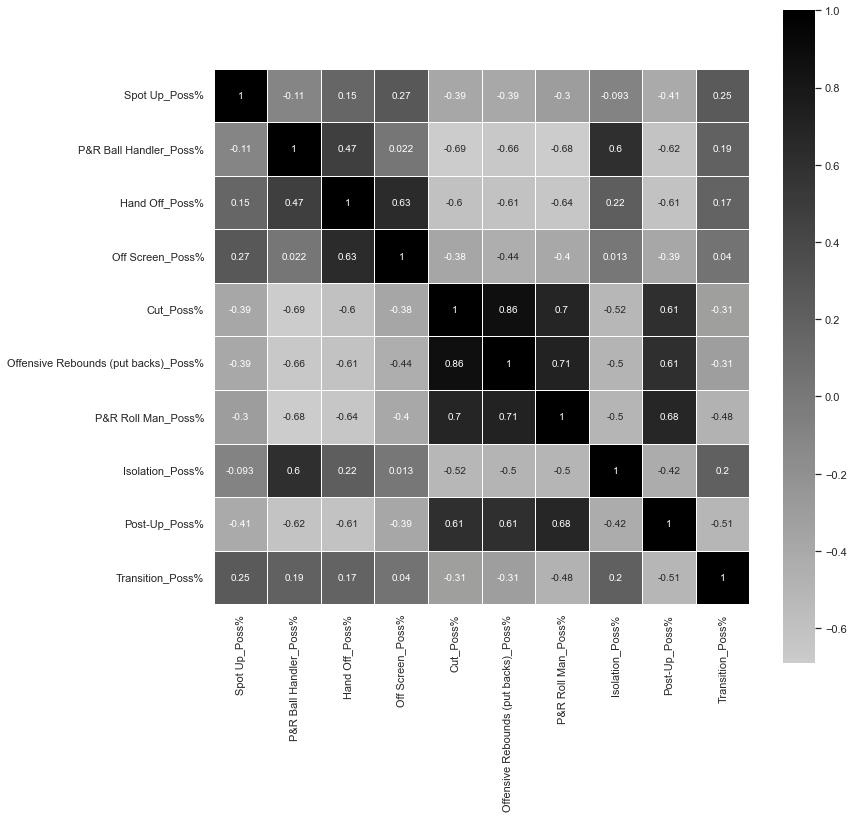

In [23]:
figsize(12, 8)
corr = df[poss_weights_cols].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5)

Show distributions of possession weights and effeiciency of each playtype

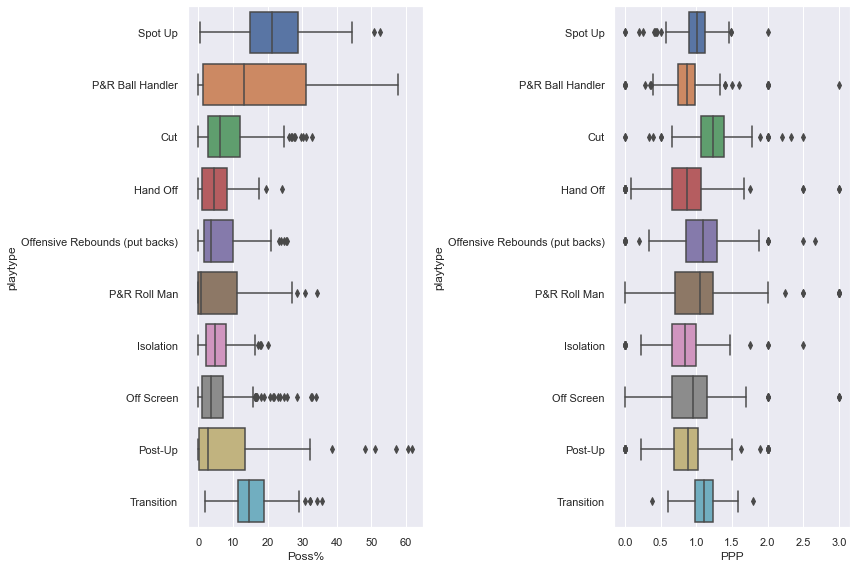

In [24]:
figsize(12, 8)
data = get_playtype_dist(df)
plt.subplot(1, 2, 1)
sns.boxplot(x="Poss%", y="playtype", data=data)
plt.subplot(1, 2, 2)
sns.boxplot(x="PPP", y="playtype", data=data)
plt.tight_layout()

Summary of distribution in playtype weights:
- Outliers exist 
    - Most of them are the result of skewed data
    - A few of them are creditted to players' own unique tendencies (ex. James Harden's iso game)
- There are some common playtypes
    - Spot Up
    - Transition
- Most are skewed
    - Big man
        - Cut
        - Offensive Rebounds
        - P&R Roll Man
        - Post-Up
    - Perimeter players
        - P&R Ball Handler
        - Hand Off
        - Off Screen
    - Star Privilege
        - Post-Up
        - Isolation
    
        

### Clustering

In [25]:
X = df[poss_weights_cols].copy()

Determine how many components reduce down to via PCA

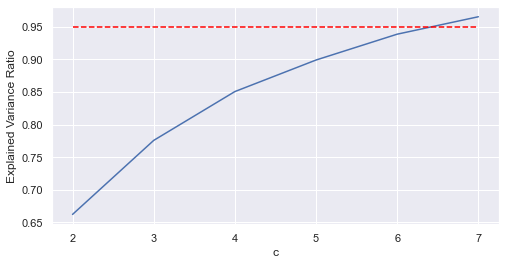

In [26]:
figsize(8, 4)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choose 6

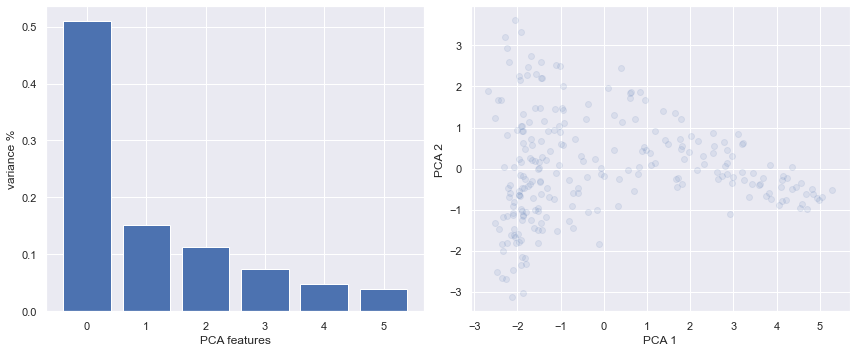

In [76]:
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=6)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [77]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

Determine # of clusters using silhouette score method

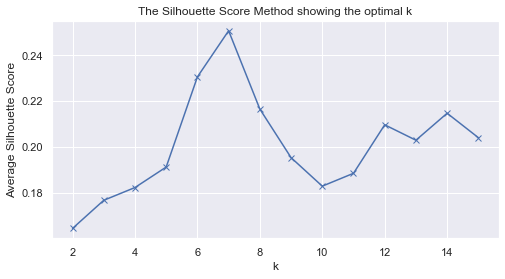

In [78]:
figsize(8, 4)
plot_silhouette_score(X_transformed)

Try 500 times to see if the clustering result stays robust. It turns out the algorithm delivers the same result 

In [30]:
# # Check stability
# check_cluster_robustness(X_transformed, 7, 500)

### Results

In [30]:
# Choose k = 7
sc = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    26
1    25
2    39
3    36
4    25
5    47
6    47
Name: Player, dtype: int64

#### OBPM & Usage by Cluster

In [31]:
show_cluster_res(df, 'player_cluster')

,0,1,2,3,4,5,6
player_cluster,0,1,2,3,4,5,6
Spot Up_Poss%,28.35%,8.76%,18.03%,16.99%,12.95%,24.43%,33.19%
P&R Ball Handler_Poss%,12.59%,0.56%,27.08%,44.06%,1.43%,16.19%,10.70%
Hand Off_Poss%,13.14%,0.46%,6.93%,8.78%,0.81%,4.25%,2.97%
Off Screen_Poss%,19.02%,0.38%,8.31%,3.85%,1.81%,3.82%,3.81%
Cut_Poss%,4.39%,22.97%,4.11%,2.37%,12.79%,8.78%,8.42%
Offensive Rebounds (put backs)_Poss%,2.68%,18.80%,2.57%,1.60%,9.28%,6.38%,6.35%
P&R Roll Man_Poss%,0.64%,18.44%,1.11%,0.17%,15.66%,2.87%,7.99%
Isolation_Poss%,2.94%,1.65%,12.15%,7.13%,2.81%,5.15%,4.25%
Post-Up_Poss%,0.88%,18.36%,3.51%,0.48%,32.50%,4.56%,8.92%


- Ballhandler: 2 & 3
- Big: 1 & 4
- Wing: 0 & 5 & 6

In [32]:
cluster_dict = {2: 'Ballhandler', 3: 'Ballhandler',
                1: 'Big', 4: 'Big',
                0: 'Wing', 5: 'Wing', 6: 'Wing'}

#### Possession Weights by Cluster

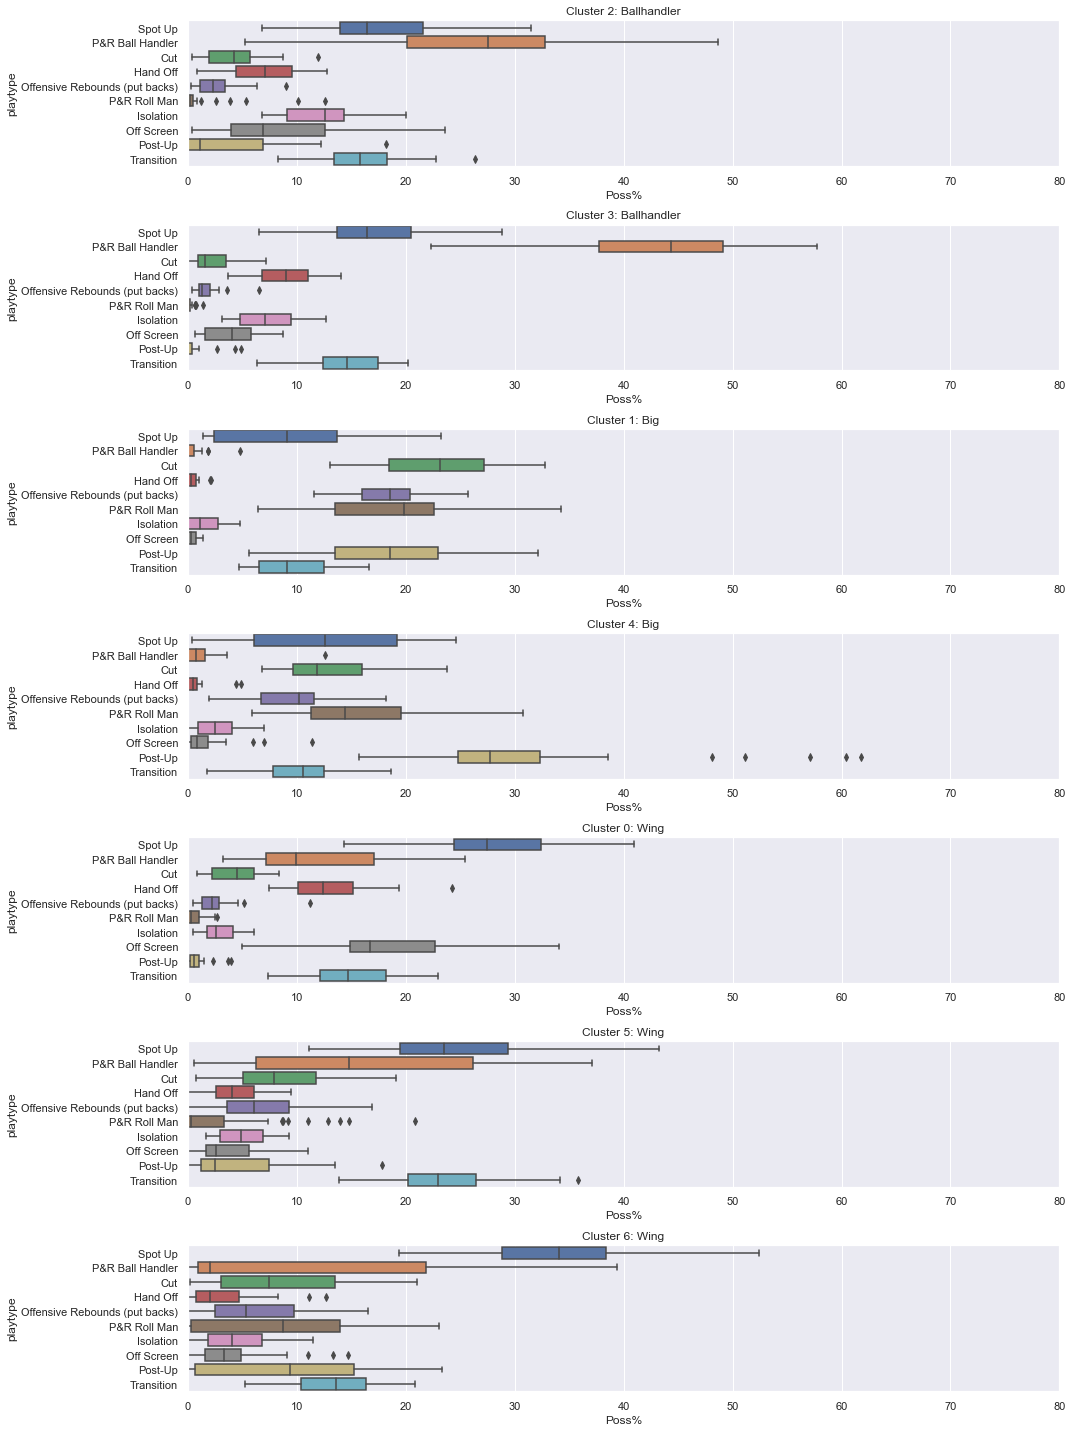

In [33]:
figsize(15, 20)
n_clusters = len(set(df['player_cluster']))
data_dict = {cluster: get_playtype_dist(df[df['player_cluster'] == cluster])
             for cluster in range(n_clusters)}

for idx, cluster in enumerate(list(cluster_dict.keys()), 1):
    data = get_playtype_dist(df[df['player_cluster'] == cluster])
    plt.subplot(n_clusters, 1, idx)
    sns.boxplot(x="Poss%", y="playtype", data=data_dict[cluster])
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}')
    plt.xlim(0, 80)

plt.tight_layout()

Summary of distribution in playtype weights:
- Good:
    - Cluster separate playtypes regarding pick & roll nicely
    - Cluster separate iso & post-up nicely
- Bad:
    - Skewed data & Outliers still exist

#### Observations

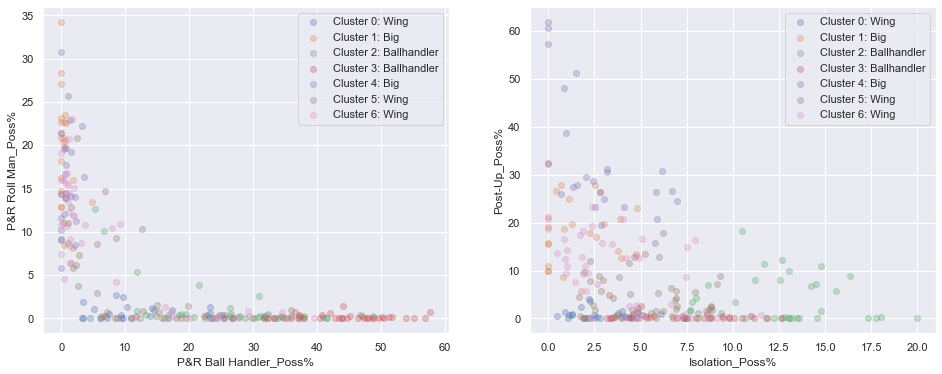

In [34]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)

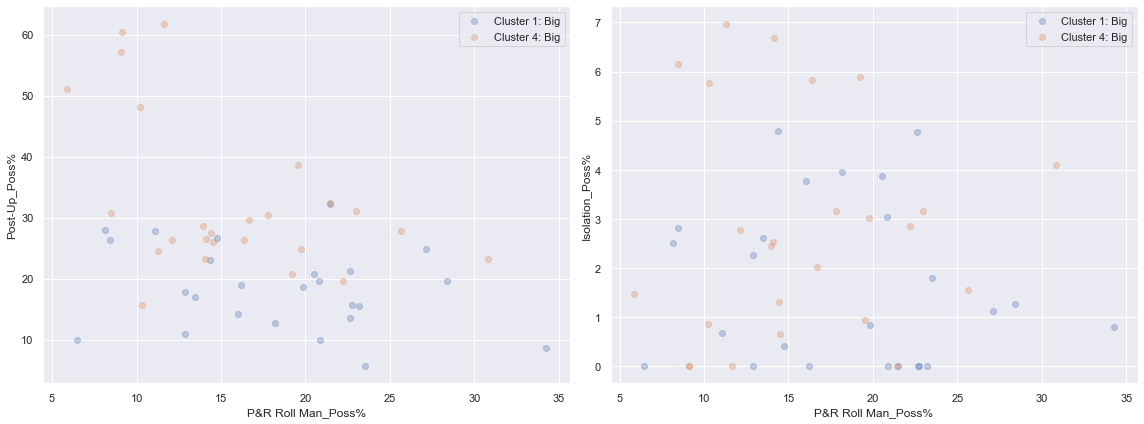

In [35]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

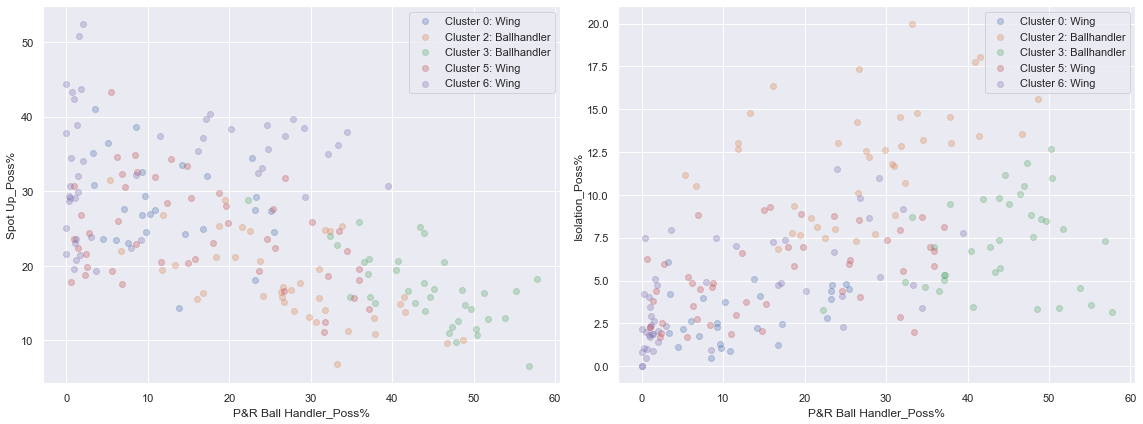

In [36]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

#### Distributions

#### Ballhandler

In [37]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 39


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Dejan Vasiljevic,2020,Sydney Kings,1.111,Mikyle McIntosh,2021,Tasmania JackJumpers,0.801
1,Kevin Lisch,2018,Sydney Kings,1.063,Xavier Rathan-Mayes,2021,Illawarra Hawks,0.804
2,Bryce Cotton,2017,Perth Wildcats,1.061,Lamelo Ball,2019,Illawarra Hawks,0.823
3,Chris Goulding,2017,Melbourne United,1.050,Lamar Patterson,2021,Brisbane Bullets,0.834
4,Demitrius Conger,2017,Illawarra Hawks,1.041,Scotty Hopson,2020,Melbourne United,0.845
5,Bryce Cotton,2021,Perth Wildcats,1.038,Corey Webster,2018,SKYCITY New Zealand Breakers,0.865
6,Sek Henry,2019,SKYCITY New Zealand Breakers,1.035,Lamar Patterson,2020,Brisbane Bullets,0.877
7,Bryce Cotton,2019,Perth Wildcats,1.033,Casper Ware,2019,Sydney Kings,0.881
8,Bryce Cotton,2020,Perth Wildcats,1.019,Casper Ware,2017,Melbourne United,0.906
9,Dejan Vasiljevic,2021,Sydney Kings,1.011,Hugo Besson,2021,SKYCITY New Zealand Breakers,0.909


In [38]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 36


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,John Roberson,2019,South East Melbourne Phoenix,1.103,Scott Machado,2021,Cairns Taipans,0.661
1,Nathan Sobey,2020,Brisbane Bullets,1.045,Mitch McCarron,2021,Adelaide 36ers,0.706
2,Jaylen Adams,2021,Sydney Kings,1.016,Josh Giddey,2020,Adelaide 36ers,0.779
3,Melo Trimble,2018,Cairns Taipans,1.005,Josh Magette,2021,Tasmania JackJumpers,0.807
4,Kyle Adnam,2019,South East Melbourne Phoenix,1.004,Tai Webster,2020,SKYCITY New Zealand Breakers,0.817
5,Melo Trimble,2019,Melbourne United,0.998,Shea Ili,2017,SKYCITY New Zealand Breakers,0.829
6,Tyler Harvey,2020,Illawarra Hawks,0.981,Matthew Dellavedova,2021,Melbourne United,0.843
7,Corey Webster,2019,SKYCITY New Zealand Breakers,0.977,Jarrad Weeks,2017,Cairns Taipans,0.846
8,Jerome Randle,2019,Adelaide 36ers,0.973,Scott Machado,2020,Cairns Taipans,0.868
9,Xavier Munford,2021,South East Melbourne Phoenix,0.956,Peyton Siva,2021,SKYCITY New Zealand Breakers,0.879


#### Big

In [41]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 25


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Yannick Wetzell,2021,SKYCITY New Zealand Breakers,1.179,Tai Wesley,2019,South East Melbourne Phoenix,0.817
1,Jock Landale,2020,Melbourne United,1.096,Ariel Hukporti,2021,Melbourne United,0.919
2,Daniel Kickert,2017,Brisbane Bullets,1.082,David Andersen,2018,Illawarra Hawks,0.929
3,Shawn Long,2019,Melbourne United,1.077,Brian Conklin,2018,Illawarra Hawks,0.944
4,Daniel Johnson,2020,Adelaide 36ers,1.056,Tai Wesley,2017,Melbourne United,0.948
5,Daniel Johnson,2019,Adelaide 36ers,1.055,Nathan Jawai,2018,Cairns Taipans,0.955
6,Daniel Johnson,2018,Adelaide 36ers,1.052,Angus Brandt,2018,Perth Wildcats,0.958
7,Daniel Kickert,2018,Sydney Kings,1.044,Daniel Johnson,2021,Adelaide 36ers,0.980
8,Nathan Jawai,2020,Cairns Taipans,1.031,Nathan Jawai,2019,Cairns Taipans,0.984
9,Angus Brandt,2017,Perth Wildcats,1.028,Mitchell Creek,2021,South East Melbourne Phoenix,0.985


In [42]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 25


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Zhou Qi,2021,South East Melbourne Phoenix,1.188,Mika Vukona,2017,SKYCITY New Zealand Breakers,0.757
1,Shawn Long,2018,SKYCITY New Zealand Breakers,1.126,A.J. Ogilvy,2019,Illawarra Hawks,0.851
2,Ben Moore,2020,South East Melbourne Phoenix,1.110,Cameron Bairstow,2021,Adelaide 36ers,0.874
3,Josh Boone,2017,Melbourne United,1.106,A.J. Ogilvy,2018,Illawarra Hawks,0.878
4,Colton Iverson,2020,SKYCITY New Zealand Breakers,1.081,Josh Boone,2019,Illawarra Hawks,0.891
5,Matthew Hodgson,2018,Brisbane Bullets,1.077,Cameron Bairstow,2018,Brisbane Bullets,0.941
6,Matthew Hodgson,2019,Brisbane Bullets,1.075,Mason Peatling,2020,Melbourne United,0.946
7,Brandon Ashley,2019,SKYCITY New Zealand Breakers,1.068,Andrew Bogut,2019,Sydney Kings,0.963
8,R.J. Hunter,2020,Sydney Kings,1.066,Andrew Bogut,2018,Sydney Kings,0.963
9,John Mooney,2020,Perth Wildcats,1.064,Josh Boone,2018,Melbourne United,0.997


#### Wing

In [43]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 26


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Thomas Abercrombie,2019,SKYCITY New Zealand Breakers,1.211,Kouat Noi,2019,Cairns Taipans,0.870
1,Jason Cadee,2019,Brisbane Bullets,1.165,Clint Steindl,2020,Perth Wildcats,0.888
2,Clint Steindl,2019,Perth Wildcats,1.141,Thomas Abercrombie,2017,SKYCITY New Zealand Breakers,0.897
3,Todd Blanchfield,2018,Illawarra Hawks,1.139,Anthony Drmic,2021,Brisbane Bullets,0.919
4,Cameron Gliddon,2018,Brisbane Bullets,1.132,Dusty Hannahs,2021,Adelaide 36ers,0.960
5,Cameron Gliddon,2020,South East Melbourne Phoenix,1.094,Chris Goulding,2018,Melbourne United,0.963
6,Kirk Penney,2017,SKYCITY New Zealand Breakers,1.093,Mirko Djeric,2020,Cairns Taipans,0.964
7,Cameron Gliddon,2017,Cairns Taipans,1.077,Thomas Abercrombie,2020,SKYCITY New Zealand Breakers,0.990
8,Clint Steindl,2018,Perth Wildcats,1.064,Chris Goulding,2021,Melbourne United,0.991
9,Chris Goulding,2019,Melbourne United,1.064,Bul Kuol,2021,Cairns Taipans,0.997


In [44]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 47


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Jaesean Tate,2019,Sydney Kings,1.200,Cedric Jackson,2018,Illawarra Hawks,0.742
1,Mitchell Creek,2017,Adelaide 36ers,1.178,Tahjere McCall,2021,Cairns Taipans,0.810
2,DJ Newbill,2019,Cairns Taipans,1.138,Justin Simon,2020,Illawarra Hawks,0.836
3,Jarell Martin,2021,Sydney Kings,1.101,Brad Newley,2020,Sydney Kings,0.845
4,Majok Deng,2021,Cairns Taipans,1.075,Shea Ili,2018,SKYCITY New Zealand Breakers,0.846
5,Majok Deng,2019,Cairns Taipans,1.073,Sunday Dech,2019,Illawarra Hawks,0.859
6,Majok Deng,2017,Adelaide 36ers,1.063,Caleb Agada,2021,Melbourne United,0.872
7,Jacob Wiley,2018,Adelaide 36ers,1.062,Mitch McCarron,2020,Melbourne United,0.873
8,Mitch McCarron,2019,Melbourne United,1.055,Nathan Sobey,2017,Adelaide 36ers,0.877
9,Josh Childress,2017,Adelaide 36ers,1.053,Shannon Shorter,2017,Adelaide 36ers,0.889


In [45]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 47


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Nick Kay,2019,Perth Wildcats,1.161,Shaun Bruce,2020,Sydney Kings,0.760
1,Robert Franks,2021,Brisbane Bullets,1.119,Finn Delany,2021,SKYCITY New Zealand Breakers,0.816
2,Nick Kay,2018,Perth Wildcats,1.114,Devon Hall,2018,Cairns Taipans,0.834
3,Perry Ellis,2017,Sydney Kings,1.083,Luke Travers,2021,Perth Wildcats,0.834
4,Cameron Oliver,2019,Cairns Taipans,1.082,Ousmane Dieng,2021,SKYCITY New Zealand Breakers,0.837
5,Jason Cadee,2017,Sydney Kings,1.077,Sunday Dech,2020,Adelaide 36ers,0.846
6,Duop Reath,2021,Illawarra Hawks,1.073,DJ Newbill,2018,Cairns Taipans,0.868
7,Jack McVeigh,2020,Adelaide 36ers,1.073,Deng Deng,2020,Illawarra Hawks,0.876
8,Jack McVeigh,2021,Tasmania JackJumpers,1.072,Reuben Te Rangi,2020,South East Melbourne Phoenix,0.877
9,Reuben Te Rangi,2018,Brisbane Bullets,1.053,Mitch Norton,2019,Perth Wildcats,0.886


#### Edge Cases

In [46]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster


In [47]:
temp[(temp['n_cluster'] == 2) & (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster


### Visualization via TSNE

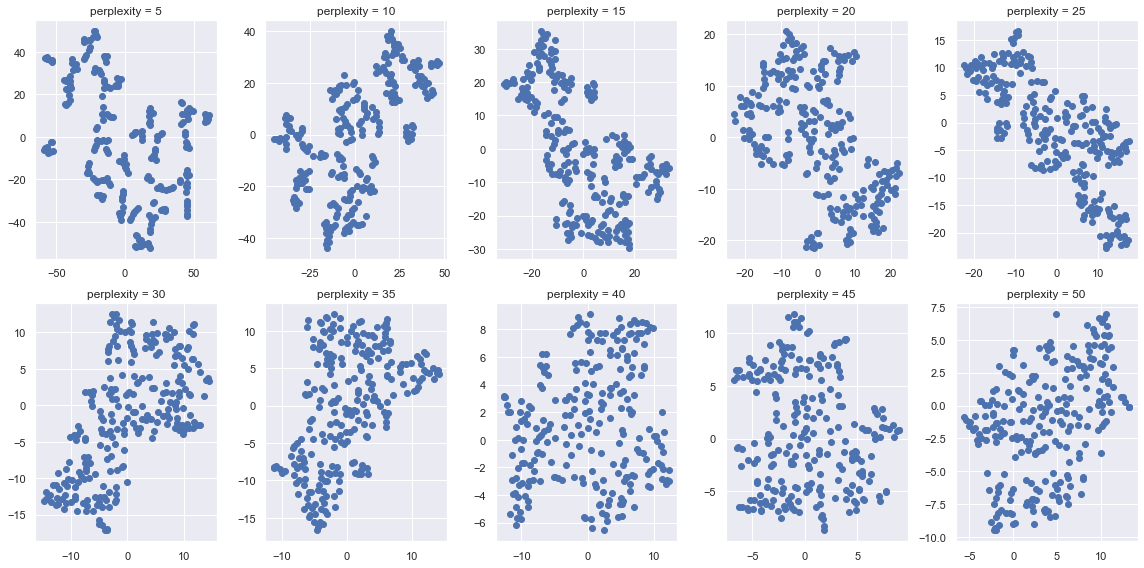

In [48]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [57]:
tsne = TSNE(perplexity=25, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

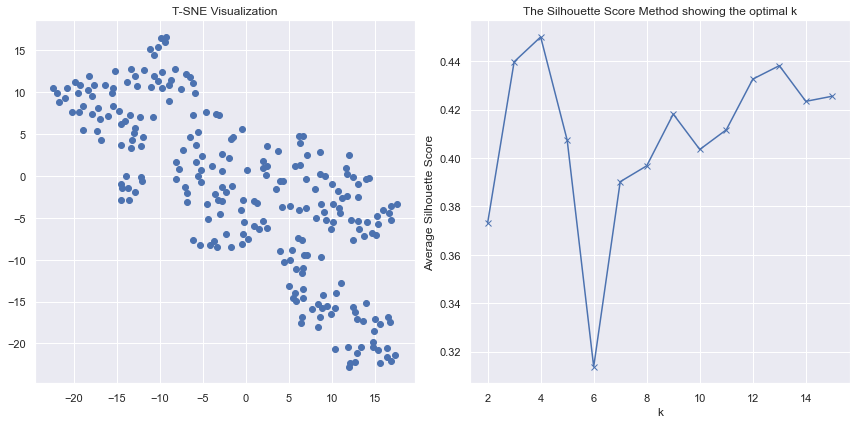

In [58]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [59]:
df_tsne = df.copy()
# Choose k = 6
sc_tsne = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

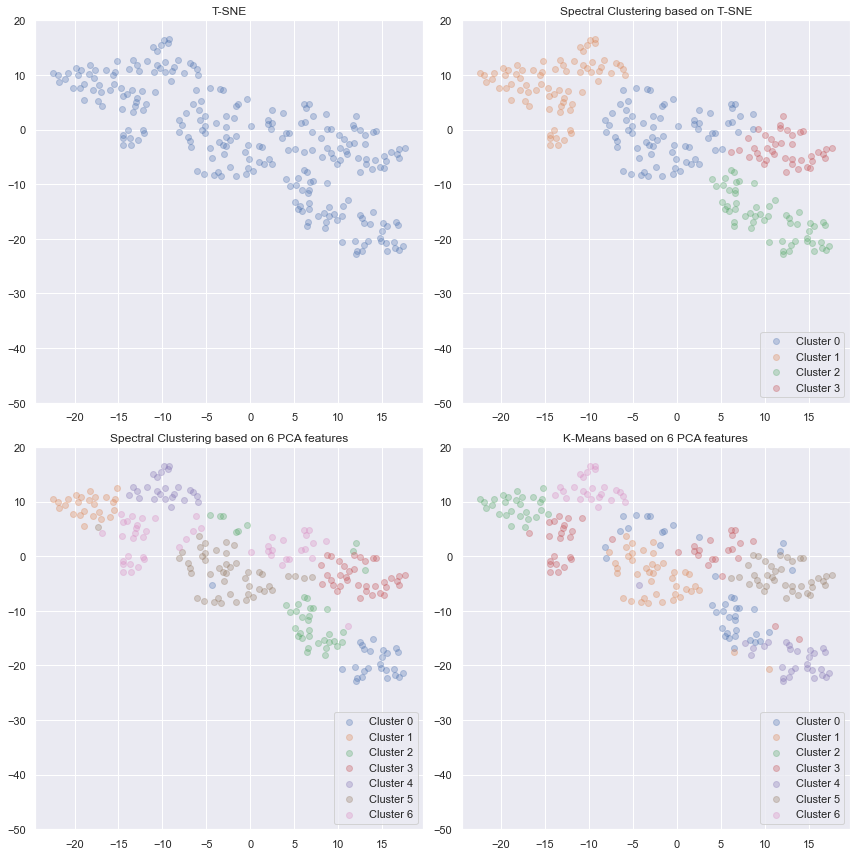

In [64]:
figsize(12, 12)

plt.subplot(2, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')
plt.ylim(-50, 20)

plt.subplot(2, 2, 2)
for i in range(4):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title('Spectral Clustering based on T-SNE')
plt.ylim(-50, 20)

n_clusters = 7

plt.subplot(2, 2, 3)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title('Spectral Clustering based on 6 PCA features')
plt.ylim(-50, 20)


plt.subplot(2, 2, 4)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title('K-Means based on 6 PCA features')
plt.ylim(-50, 20)

plt.tight_layout()

(-50.0, 20.0)

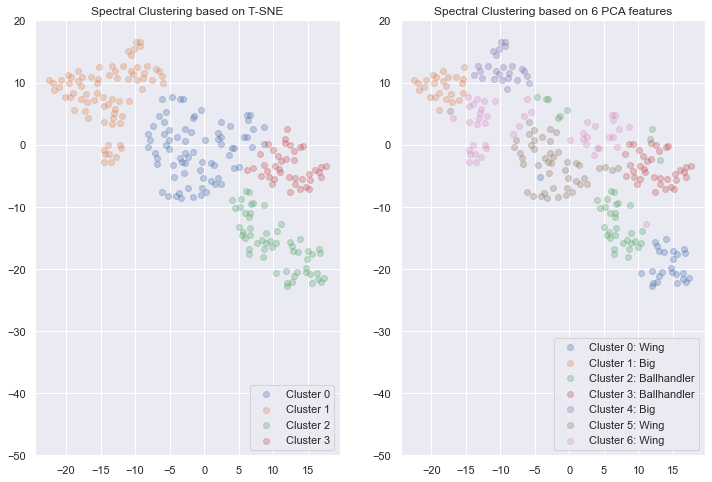

In [79]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for i in range(4):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title('Spectral Clustering based on T-SNE')
plt.ylim(-50, 20)

n_clusters = 7

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc='lower right')
plt.title('Spectral Clustering based on 6 PCA features')
plt.ylim(-50, 20)

## Save Models

In [52]:
# df.to_csv('nbl_cleaned.csv', index=False)

In [53]:
# nbl_clustering_models = {'pre_pca_pipe': pre_pca_pipe,
#                          'pca': pca,
#                          'pre_cluster_scaler': pre_cluster_scaler,
#                          'cluster_dict': cluster_dict}
# dump_pickle(nbl_clustering_models, 'nbl_clustering_models')

In [54]:
# cluster_map_km_to_sc = {0: 3, 
#                         1: 1, 
#                         2: 2, 
#                         3: 5, 
#                         4: 0, 
#                         5: 4, 
#                         6: 6}
# nbl_clustering_models_km = {'pre_pca_pipe': pre_pca_pipe,
#                             'pca': pca,
#                             'pre_cluster_scaler': pre_cluster_scaler,
#                             'cluster_map_to_spectral_clustering': cluster_map_km_to_sc,
#                             'km': km}
# dump_pickle(nbl_clustering_models_km, 'nbl_clustering_models_km')